# Learning More About my Rides from the Peloton API

After working out and analyzing the results provided by Peloton, I often wondered what more could be found in my workout data. Peloton provides okay metrics, but I would find myself asking questions like: does the music I like correlate to better performance? At any given second, how did my performance fare compared to the instructor's suggested range? Why can't I overlay the instructors ride details on my charts? 

This project is the culmination of researching what I could extract from the Peloton API and trying to better understand & analyze my workouts. Having some fun, I was able to find some seemingly tucked away information about my rides and create an interactive visualization to overlay details from my rides.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
import config
import pelo_functions as pf
import json
import textwrap
from sklearn.ensemble import RandomForestRegressor
from IPython.html import widgets
from IPython.display import display, HTML
warnings.filterwarnings("ignore")

In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))

### gathering my peloton workouts

In [3]:
# setting up peloton api session
s = requests.Session()
payload = {'username_or_email': config.username_or_email, 'password': config.password}
s.post('https://api.onepeloton.com/auth/login', json=payload)
me = s.get('https://api.onepeloton.com/api/me')
me = json.loads(me.content)
my_user_id = me["id"]

# call peloton api to retreive workout metadata
my_workouts = s.get("https://api.onepeloton.com/api/user/{}/workouts?limit=150".format(my_user_id))
my_workouts = json.loads(my_workouts.content)
my_workouts_df = pd.DataFrame.from_dict(my_workouts["data"])
my_workouts_df["ride_id"] = my_workouts_df["id"].apply(lambda x: pf.get_ride_id(x, s))

# limit to cycling workouts, convert times to datetime 
cycling_workouts = my_workouts_df[my_workouts_df["fitness_discipline"] == "cycling"].reset_index(drop=True)
cycling_workouts["start_time"] = pd.to_datetime(cycling_workouts["start_time"], unit="s")
cycling_workouts["end_time"] = pd.to_datetime(cycling_workouts["start_time"], unit="s")
cycling_workouts["created_at"] = pd.to_datetime(cycling_workouts["created_at"], unit="s")

# gather & format full details for each workout
all_workouts = pd.DataFrame()
for i in np.arange(len(cycling_workouts)):
    this_workout_id = cycling_workouts.loc[i,"id"]
    this_ride_id = cycling_workouts.loc[i,"ride_id"]
    try:
        this_workout = pf.get_complete_workout(this_workout_id, this_ride_id, s)
        this_workout["workout_id"] = this_workout_id
        this_workout["ride_id"] = this_ride_id
        this_workout["start_time"] = cycling_workouts.loc[i,"start_time"]
        this_workout["end_time"] = cycling_workouts.loc[i,"end_time"]
        this_workout["created_at"] = cycling_workouts.loc[i,"created_at"]
        all_workouts = pd.concat([all_workouts, this_workout], ignore_index=True)
    except:
        pass
    
all_workouts["detailed_class_title"] = all_workouts["start_time"].dt.date.astype(str) + ", " + \
                                       all_workouts["instructor"] + ", " + \
                                       all_workouts["class_title"]
all_workouts.head()

,Output (watts),Cadence (rpm),Resistance (%),Speed (mph),time (s),intensity_in_mets,name,display_name,segment_type,upper_resistance,...,average_effort_score,total_heart_rate_zone_durations,instructor,class_title,workout_id,ride_id,start_time,end_time,created_at,detailed_class_title
0,48.0,82.0,28.0,11.7,0.0,3.5,Warm Up,Flat Road,cycling,32,...,None,None,Alex Toussaint,30 min Club Bangers Ride,718e3513448548c59d4fde2836515a7f,73122c56a95a4e60a94fbf856ba4b163,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger..."
1,49.0,83.0,28.0,11.9,1.0,3.5,Warm Up,Flat Road,cycling,32,...,None,None,Alex Toussaint,30 min Club Bangers Ride,718e3513448548c59d4fde2836515a7f,73122c56a95a4e60a94fbf856ba4b163,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger..."
2,49.0,83.0,28.0,11.9,2.0,3.5,Warm Up,Flat Road,cycling,32,...,None,None,Alex Toussaint,30 min Club Bangers Ride,718e3513448548c59d4fde2836515a7f,73122c56a95a4e60a94fbf856ba4b163,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger..."
3,47.0,82.0,28.0,11.7,3.0,3.5,Warm Up,Flat Road,cycling,32,...,None,None,Alex Toussaint,30 min Club Bangers Ride,718e3513448548c59d4fde2836515a7f,73122c56a95a4e60a94fbf856ba4b163,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger..."
4,48.0,81.0,30.0,11.8,4.0,3.5,Warm Up,Flat Road,cycling,32,...,None,None,Alex Toussaint,30 min Club Bangers Ride,718e3513448548c59d4fde2836515a7f,73122c56a95a4e60a94fbf856ba4b163,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger..."


In [4]:
# peloton provides the upper and lower range for resistance and cadence, but not output (a combination of the two)
# here, I am using a simple model to pinpoint the relationship between the two (and add output ranges to the dataset)
rf = RandomForestRegressor()
training_set = all_workouts.dropna(subset=["Cadence (rpm)", "Resistance (%)", "Output (watts)"])
X = training_set[["Cadence (rpm)", "Resistance (%)"]]
y = training_set["Output (watts)"]
rf.fit(X, y)

#formatting new output range columns
valid_upper = all_workouts[["upper_cadence", "upper_resistance"]].dropna()
valid_lower = all_workouts[["lower_cadence", "lower_resistance"]].dropna()
all_workouts["upper_output_est"] = np.nan
all_workouts["lower_output_est"] = np.nan
all_workouts.loc[valid_upper.index, "upper_output_est"] = rf.predict(valid_upper)
all_workouts.loc[valid_lower.index, "lower_output_est"] = rf.predict(valid_lower)
all_workouts["Upper output delta"] = all_workouts["Output (watts)"] - all_workouts["upper_output_est"]
all_workouts["Upper output delta"] = all_workouts["Upper output delta"].apply(lambda x: max(0, x))
all_workouts["Lower output delta"] = all_workouts["Output (watts)"] - all_workouts["lower_output_est"]
all_workouts["Lower output delta"] = all_workouts["Lower output delta"].apply(lambda x: min(0, x))
all_workouts["Output delta"] = all_workouts[["Lower output delta", "Upper output delta"]].apply(lambda x: 0 if sum(x)==0 else sum(x), axis=1)
all_workouts["first_artist"] = all_workouts["artist"].str.split(",").str[0]
all_workouts.head()

,Output (watts),Cadence (rpm),Resistance (%),Speed (mph),time (s),intensity_in_mets,name,display_name,segment_type,upper_resistance,...,start_time,end_time,created_at,detailed_class_title,upper_output_est,lower_output_est,Upper output delta,Lower output delta,Output delta,first_artist
0,48.0,82.0,28.0,11.7,0.0,3.5,Warm Up,Flat Road,cycling,32,...,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger...",93.894801,47.75,0.0,0.00,0.00,Ying Yang Twins
1,49.0,83.0,28.0,11.9,1.0,3.5,Warm Up,Flat Road,cycling,32,...,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger...",93.894801,47.75,0.0,0.00,0.00,Ying Yang Twins
2,49.0,83.0,28.0,11.9,2.0,3.5,Warm Up,Flat Road,cycling,32,...,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger...",93.894801,47.75,0.0,0.00,0.00,Ying Yang Twins
3,47.0,82.0,28.0,11.7,3.0,3.5,Warm Up,Flat Road,cycling,32,...,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger...",93.894801,47.75,0.0,-0.75,-0.75,Ying Yang Twins
4,48.0,81.0,30.0,11.8,4.0,3.5,Warm Up,Flat Road,cycling,32,...,2022-06-29 23:40:25,2022-06-29 23:40:25,2022-06-29 23:40:02,"2022-06-29, Alex Toussaint, 30 min Club Banger...",93.894801,47.75,0.0,0.00,0.00,Ying Yang Twins


## Interactive ride analysis

Using the ipython library, I am able to create an interactive way to choose workouts, select metrics to view, and overlay different workout details. 

On Peloton, you are given the time series for the different available metrics. However, it can be difficult to discern your performance without comparison to some sort of baseline. During the ride, the instructor gives you a target range for cadence/resistance, but those ranges are not included in the post-workout details. Pretty frustrating... alas, I was able to find these details in the peloton API and made a way to visualize them. In the visualization, I highlight areas of the workout where my performance fell above (green) or below (red) the instructor's target range, really helping me contextualize my performance.

In addition to this, I am able to find a way to overlay the different music in the ride, as well as the different ride segments (warm-up, climb, flat road, etc).

In [5]:
from IPython.html import widgets
from IPython.display import display

dropdown_workouts = list(all_workouts["detailed_class_title"].drop_duplicates())
dropdown_metrics = ["Output (watts)", "Cadence (rpm)", "Resistance (%)"]
dropdown_overlays = ["music", "segments", "no overlay"]

def print_selections(workout, metric, overlay):
    selected_workout = all_workouts[all_workouts["detailed_class_title"] == workout].fillna(0).reset_index(drop=True)
    global selected_workout_id
    global selected_ride_id
    selected_workout_id = selected_workout["workout_id"].values[0]
    selected_ride_id = selected_workout["ride_id"].values[0]
    print()
    print("workout_id: " + str(selected_workout_id))
    print("ride_id: " + str(selected_ride_id))
    print()
    pf.plot_workout(selected_workout, metric, overlay)
    
workout_widget = widgets.Dropdown(options=dropdown_workouts)
metric_widget = widgets.Dropdown(options=dropdown_metrics)
overlay_widget = widgets.Dropdown(options=dropdown_overlays)

j = widgets.interactive(print_selections, workout=workout_widget, metric=dropdown_metrics, overlay=overlay_widget)
display(j)

interactive(children=(Dropdown(description='workout', options=('2022-06-29, Alex Toussaint, 30 min Club Banger…

### sample rides

show the output-music overlays for 5 sample rides

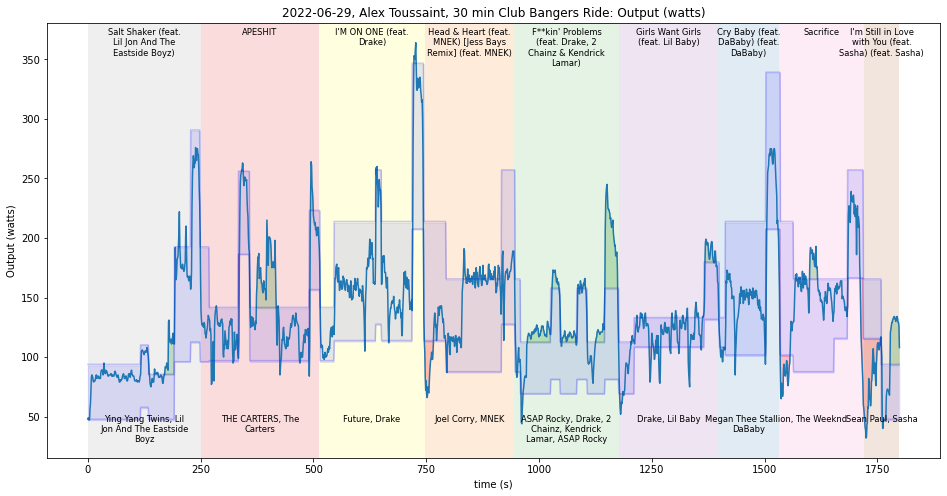

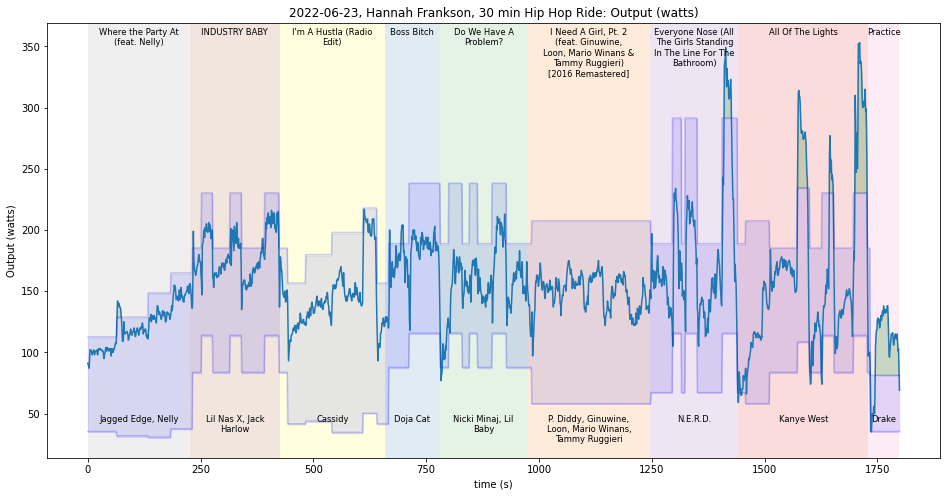

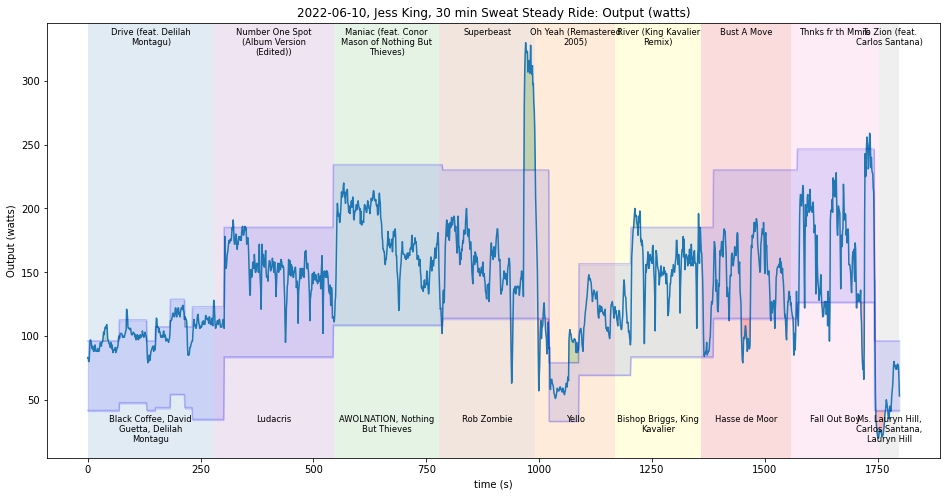

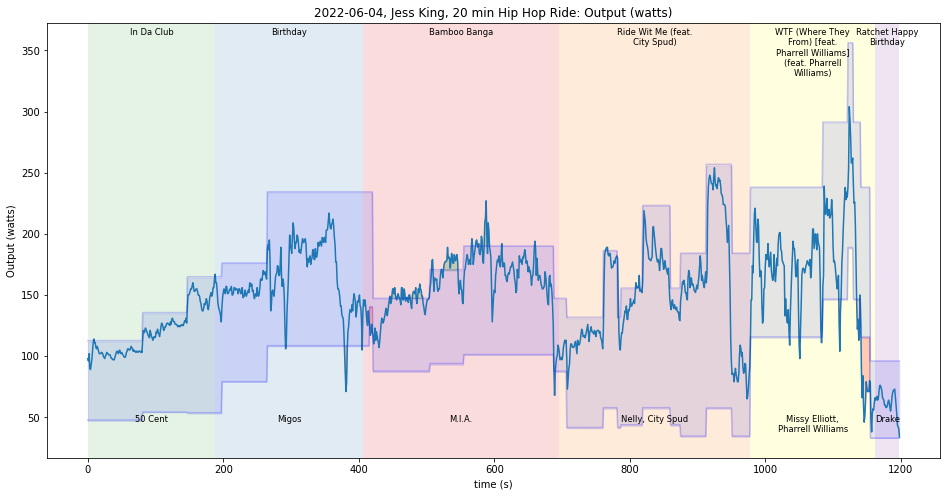

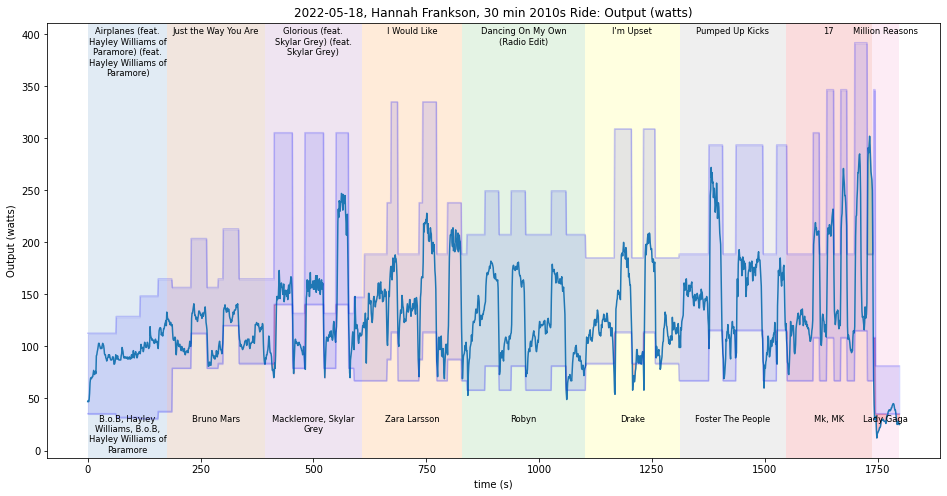

In [6]:
for workout_id in all_workouts["workout_id"].drop_duplicates()[:5]:
    this_workout = all_workouts[all_workouts["workout_id"] == workout_id].reset_index(drop=True)
    this_workout = this_workout.dropna(subset=["Output (watts)"])
    pf.plot_workout(this_workout, "Output (watts)", "music")

## Music Analysis

#### Top 10 songs based on output delta

The "output delta" is defined as the area above or below the instructor's target range. This is a great metric for understanding if I am under/overperforming.

I am pleasantly surprised when looking at my top 10 songs based on this metric! Many of my "best-performing" songs are my favorites. 

In [7]:
no_cool_downs = all_workouts[(all_workouts["name"] != "Cool Down") & (all_workouts["display_name"] != "Flat Road")]
no_cool_downs["title"] = no_cool_downs["title"].str.replace("$", "")
pd.DataFrame(no_cool_downs.groupby(["first_artist", "title"])["Output delta"].mean()).reset_index().sort_values("Output delta", ascending=False).head(10)

,first_artist,title,Output delta
344,Outkast,Prototype,91.661180
410,Statik Selektah,"Keep It Moving (feat. Nas, Joey Bada & Gary Cl...",49.664610
247,Lady Gaga,Million Reasons,34.201513
202,Joey Bada$$,DEVASTATED,31.960733
182,J. Cole,Can't Get Enough (feat. Trey Songz),23.621081
186,J. Cole,She Knows (feat. Amber Coffman & Cults),23.186419
385,Remy Ma,"Whuteva (12"" Version)",22.967199
60,Boyz N Da Hood,Dem Boyz,20.004070
333,Nicki Minaj,Feeling Myself (feat. Beyoncé),19.354740
414,Styx,Come Sail Away,19.183525


#### My Performance for Most Popular Artists

Here, I analyze how my output delta corresponds to the artist I was listening to. The most played artists in my rides by far are Drake and Kanye West. It is interesting to see that my performance netted positive for Drake, but negative for Kanye, considering I enjoy both. I also happen to really jam to J. Cole!

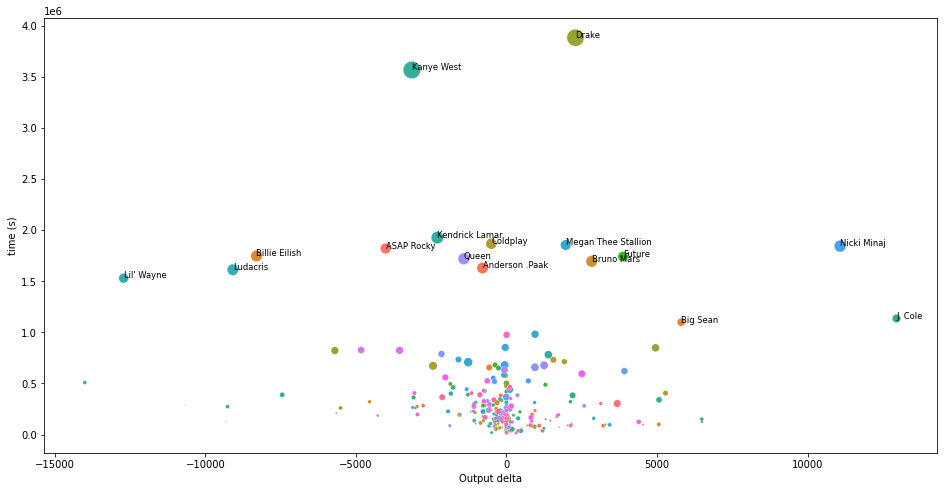

In [17]:
song_summaries = all_workouts.groupby("first_artist").sum().reset_index()
song_summaries["first_artist"] = song_summaries["first_artist"].str.replace("$", "S")
song_summaries["Output per s"] = song_summaries["Output (watts)"] / song_summaries["time (s)"]

fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(ax=ax, data=song_summaries, x="Output delta", y="time (s)", size="Speed (mph)", hue="first_artist", legend=False, sizes=(1, 300))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), fontsize="small")

points_to_label = song_summaries[song_summaries["time (s)"] > np.percentile(song_summaries["time (s)"], 94)]
label_point(points_to_label["Output delta"], points_to_label["time (s)"], points_to_label["first_artist"], plt.gca())  
plt.show()

#### When times are tough, curse!

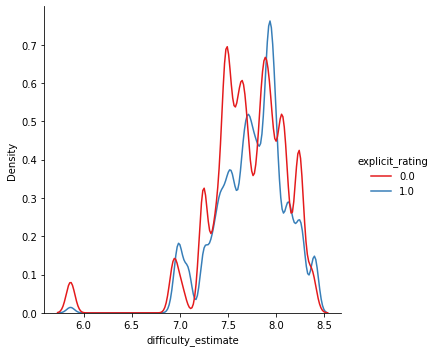

In [9]:
sns.displot(ax=ax, data=all_workouts, x="difficulty_estimate", hue="explicit_rating", kind="kde", palette="Set1");

### other fun EDA

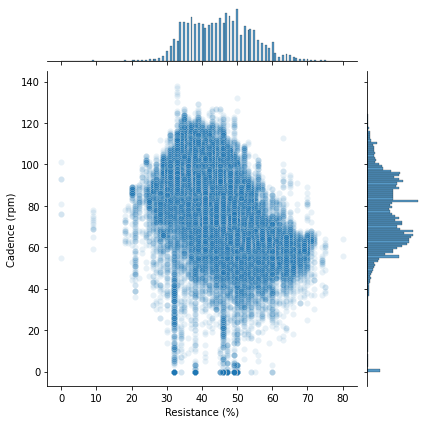

In [10]:
sns.jointplot(data=all_workouts, x="Resistance (%)", y="Cadence (rpm)", alpha=0.1)

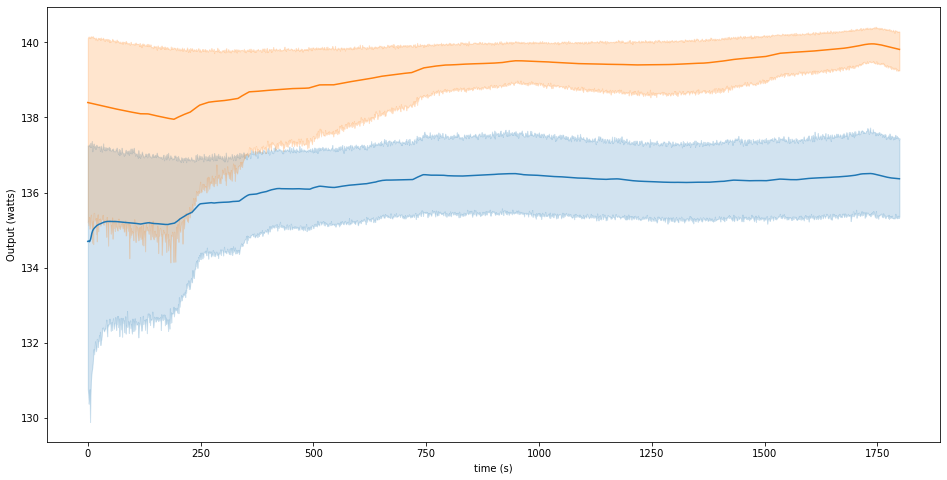

In [11]:
plt.figure(figsize=(16,8))
sns.lineplot(data=all_workouts[all_workouts["class_title"].str.contains("30 min").fillna(False)], x="time (s)", y=all_workouts["Output (watts)"].expanding().mean())
sns.lineplot(data=all_workouts[all_workouts["class_title"].str.contains("30 min").fillna(False)], x="time (s)", y=all_workouts[["upper_output_est", "lower_output_est"]].mean(axis=1).expanding().mean());